# Preliminary experiment to examine the effect of the numbers of forward passes to the consistency of the certainty estimate 

### Import the libraries 

In [1]:
import os
import csv
import numpy as np
import pickle
import seaborn as sns
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
%matplotlib inline 

### Initialize some paths and parameters

In [2]:
resultsdir = "/home/pieter/maskAL/results/preliminary_exp1"

font_size = 15
digit_size = 14

fps = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
ranges = [[0.0, 0.25], [0.25, 0.50], [0.50, 0.75], [0.75, 1.0]]
probs = [0.25, 0.50, 0.75]

### Plot the processed data - absolute difference

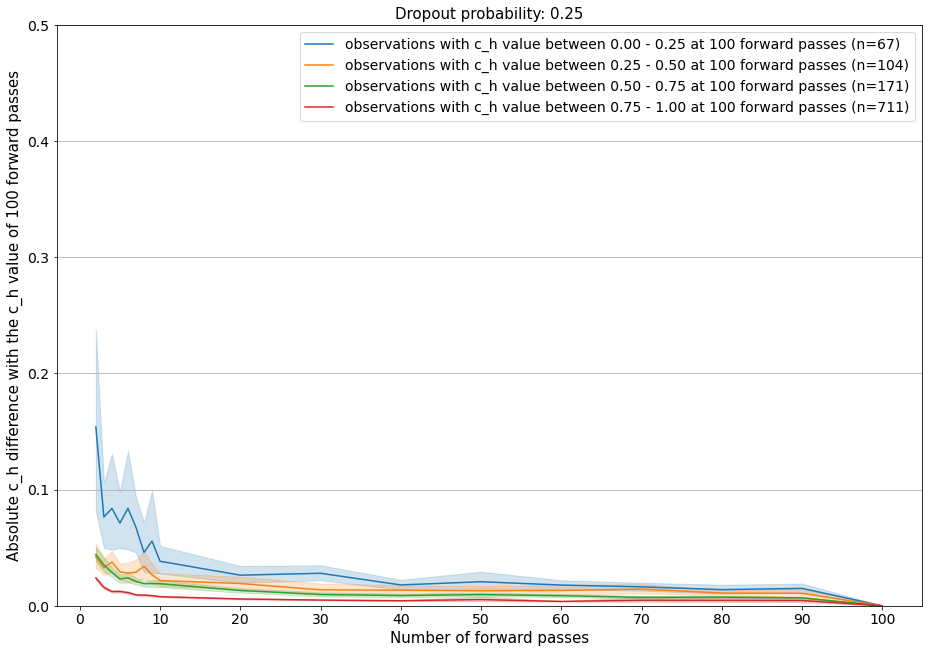

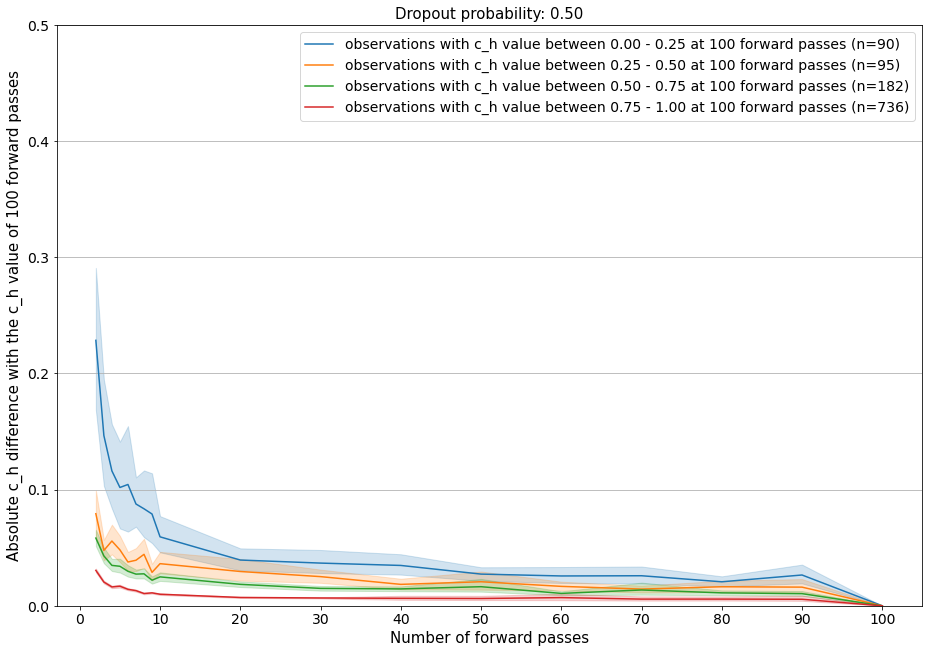

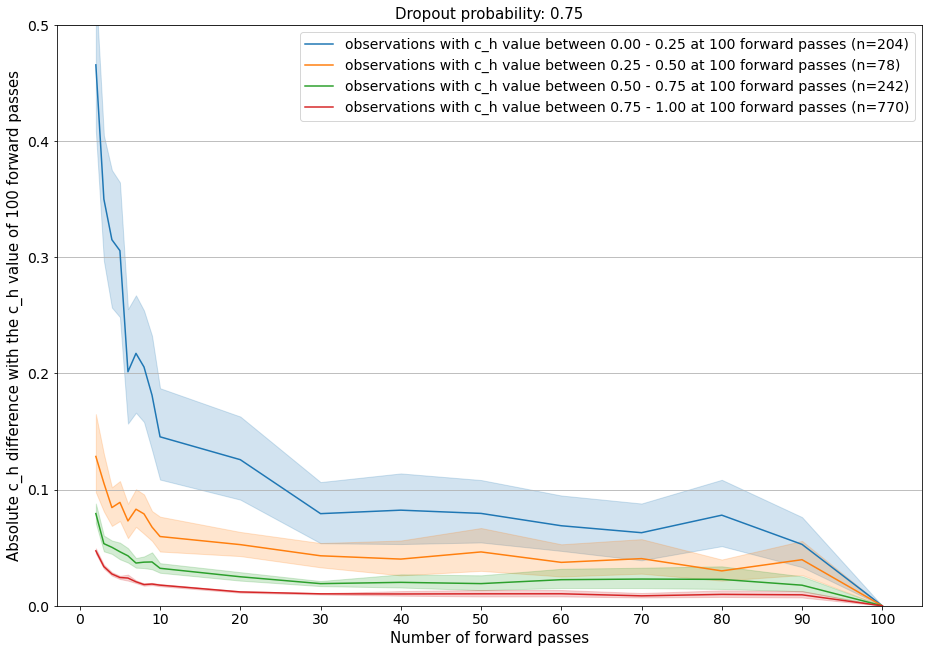

In [3]:
for p in range(len(probs)):
    prob = probs[p]
    pkl_file = "uncertainty_metrics_prob_{:.2f}.pkl".format(prob)

    strs = ["fp_{:d}".format(fps[f]) for f in range(len(fps))]
    strs.insert(0,"val_100")
    strs.insert(0,"image")
    fr = {}

    df = pd.DataFrame(columns=strs)

    with open(os.path.join(resultsdir, pkl_file), 'rb') as handle:
        uncertainties = pickle.load(handle)
        for key, val in uncertainties.items():
            transposed = list(zip(*val))
            for t in range(len(transposed)):
                obs = transposed[t]
                abs_diff = [abs(obs[o]-obs[-1]) for o in range(len(obs))]
                data = [key, obs[-1]]           
                for apd in range(len(abs_diff)):
                    data.append(abs_diff[apd])
                df_length = len(df)
                df.loc[df_length] = data

    f, ax = plt.subplots(figsize=(13, 9))
    legends = []

    for r in range(len(ranges)):
        sel = df[df['val_100'].between(ranges[r][0], ranges[r][1])].loc[:, 'fp_2':'fp_100']
        dff = pd.DataFrame(columns=['fp', 'abs_diff'])

        selnp = sel.to_numpy()
        selnp.transpose(1,0)
        for i in range(selnp.shape[0]):
            for j in range(len(selnp[i,:])):
                data = [fps[j], selnp[i,j]]
                dff_length = len(dff)
                dff.loc[dff_length] = data
                
        legends.append("observations with c_h value between {:.2f} - {:.2f} at 100 forward passes (n={:d})".format(ranges[r][0], ranges[r][1], int((len(dff)/(len(fps)-1)))))

        if not dff.empty:
            ax = sns.lineplot(x='fp', y='abs_diff', ci=95, data=dff, palette = "tab10", legend="full")

    ax.tick_params(labelrotation=0, labelsize=digit_size)
    ax.legend(legends, fontsize=digit_size, loc='upper right')
    ax.yaxis.grid(True)
    plt.ylim([0, 0.5])
    plt.xticks(np.arange(0, 110, step=10))

    plt.xlabel("Number of forward passes", fontsize=font_size)
    plt.ylabel("Absolute c_h difference with the c_h value of 100 forward passes", fontsize=font_size)

    plt.tight_layout()
    plt.title('Dropout probability: {:.2f}'.format(prob), fontsize = font_size)
    plt.savefig(os.path.join(resultsdir, 'prob_{:.2f}.jpg'.format(prob)))
    plt.show()

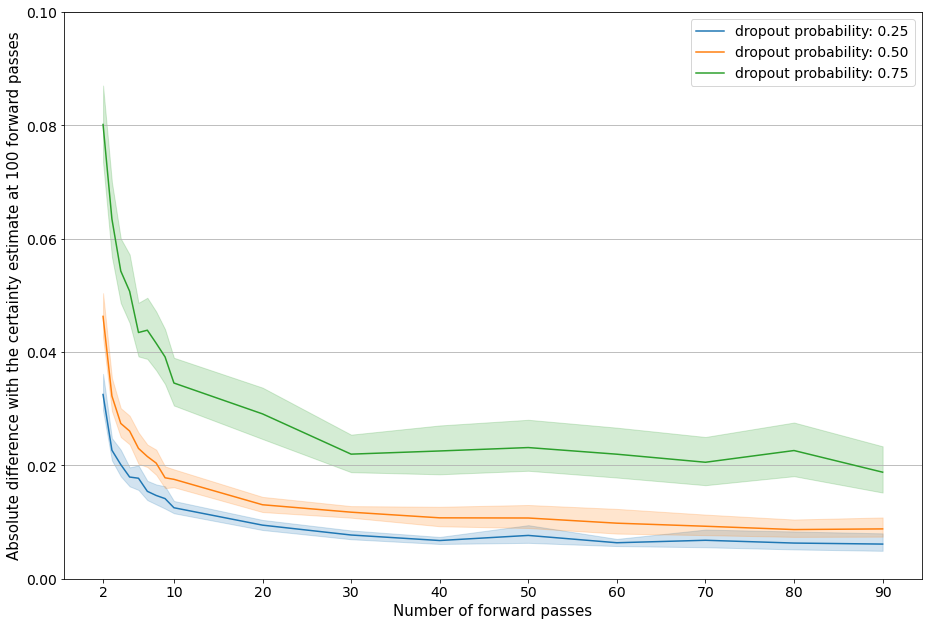

In [4]:
dff = pd.DataFrame(columns=['prob', 'fp', 'abs_diff'])
legends = []

for p in range(len(probs)):
    prob = probs[p]
    pkl_file = "uncertainty_metrics_prob_{:.2f}.pkl".format(prob)

    strs = ["fp_{:d}".format(fps[f]) for f in range(len(fps))]
    strs.insert(0,"val_100")
    strs.insert(0,"image")
    fr = {}

    df = pd.DataFrame(columns=strs)

    with open(os.path.join(resultsdir, pkl_file), 'rb') as handle:
        uncertainties = pickle.load(handle)
        for key, val in uncertainties.items():
            transposed = list(zip(*val))
            for t in range(len(transposed)):
                obs = transposed[t]
                abs_diff = [abs(obs[o]-obs[-1]) for o in range(len(obs))]
                data = [key, obs[-1]]           
                for apd in range(len(abs_diff)):
                    data.append(abs_diff[apd])
                df_length = len(df)
                df.loc[df_length] = data
       
    sel = df[df['val_100'].between(0.0, 1.0)].loc[:, 'fp_2':'fp_90']  
    selnp = sel.to_numpy()
    selnp.transpose(1,0)
    for i in range(selnp.shape[0]):
        for j in range(len(selnp[i,:])):
            data = [prob, fps[j], selnp[i,j]]
            dff_length = len(dff)
            dff.loc[dff_length] = data
            
    legends.append("dropout probability: {:.2f}, number of instance sets: {:d}".format(prob, len(df)))

if not dff.empty:
    f, ax = plt.subplots(figsize=(13, 9))
    ax = sns.lineplot(x='fp', y='abs_diff', hue='prob', ci=95, data=dff, palette = "tab10", legend="full")
    ax.tick_params(labelrotation=0, labelsize=digit_size)
    ax.legend(legends, fontsize=digit_size, loc='upper right')
    ax.yaxis.grid(True)
    plt.ylim([0, 0.1])
    plt.xticks((2, 10, 20, 30, 40, 50, 60, 70, 80, 90))

    plt.xlabel("Number of forward passes", fontsize=font_size)
    plt.ylabel("Absolute difference with the certainty estimate at 100 forward passes", fontsize=font_size)

    plt.tight_layout()
    plt.savefig(os.path.join(resultsdir, 'combined.jpg'))
    plt.show()